# Project 1: K-Nearest Neighbors (KNN) Regressor

## Question 1: KNN Regressor

In this question, we implement a KNN Regressor from scratch following the scikit-learn interface. We then test our implementation on the diabetes dataset and evaluate its performance using Mean Squared Error (MSE).


In [14]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class KnnRegressor(BaseEstimator):
    """
    K-Nearest Neighbors regressor implementation.
    
    Parameters:
    -----------
    k : int, default=5
        Number of neighbors to use for prediction.
    """
    
    def __init__(self, k=5):
        """Initialize the KNN regressor with the specified number of neighbors."""
        self.k = k
    
    def fit(self, X, y):
        """
        Fit the model using X as training data and y as target values.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
        """
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X_test):
        """
        Predict the target values for the provided test data.
        
        Parameters:
        -----------
        X_test : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        predictions : array, shape (n_samples,)
            Predicted target values
        """
        predictions = []
        for x in X_test:
            # Calculate Euclidean distances between the test point and all training points
            distances = np.sqrt(np.sum((self.X_train - x) ** 2, axis=1))
            #Take the square root of the sum of squared differences between x and each row in self.X_train."
            #axis=1 ⇒ Operate within each "row" → Used to compute values across each sample (row-wise processing), such as calculating the distance for each sample.
            #axis=0 ⇒ Operate within each "column" → Commonly used to compute statistics for each feature (column-wise processing), such as mean or variance.

            
            # Get indices of the k nearest neighbors
            k_indices = np.argsort(distances)[:self.k]
            #"Sort the distances in ascending order, and take the first k indices — these correspond to the k nearest neighbors."
            
            # Get the target values of the k nearest neighbors using the indices
            k_nearest_labels = self.y_train[k_indices]
            
            # Take the average of the k nearest targets and append it as the prediction.
            predictions.append(np.mean(k_nearest_labels))
            
        return np.array(predictions)

# Load the diabetes dataset
data = load_diabetes()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.data, 
    data.target, 
    test_size=0.3, 
    random_state=42
)

# Initialize and train the KNN regressor
knn = KnnRegressor(k=5)
knn.fit(X_train, y_train)

# Make predictions on training and test sets
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Calculate and print performance metrics
print(f"Train MSE: {mean_squared_error(y_train, y_pred_train):.6f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test):.6f}")


Train MSE: 2627.170744
Test MSE: 3222.117895



## Question 2: L-Fold Cross-Validation

Here we implement a custom L-Fold cross-validation splitter and evaluate KNN regression performance for values of K from 1 to 30.  
The model is evaluated over multiple folds, and the results are visualized with 95% confidence intervals.


In [6]:
# PART I: L-Fold Cross Validation 
class LFold:
    """
    Implementation of L-fold cross-validation.
    
    Parameters:
    -----------
    L : int, default=5
        Number of folds
    random_state : int or None, default=None
        Seed for random number generator for reproducibility
    """
    #Reproducibility means ensuring that the results of a machine learning experiment are consistent across multiple runs. 
    
    def __init__(self, L=5, random_state=None):
        self.L = L
        self.random_state = random_state
    
    def get_n_splits(self, X=None, y=None, groups=None):
        """Return the number of splitting iterations in the cross-validator."""
        return self.L
    
    def split(self, X, y=None, groups=None):
        """
        Generate indices to split data into training and test sets.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Data to split
        y : ignored
            For compatibility
        groups : ignored
            For compatibility
            
        Yields:
        -------
        train_idx : ndarray
            Training set indices
        test_idx : ndarray
            Test set indices
        """
        n_samples = len(X)
        indices = np.arange(n_samples)
        
        # Shuffle indices if random_state is provided so that the folds created later are randomized.
        if self.random_state is not None:
            np.random.seed(self.random_state)
            np.random.shuffle(indices)
        
        fold_size = n_samples // self.L
        
        for i in range(self.L):
            # Calculate test indices for current fold
            test_start = i * fold_size
            
            #This is to handle the situation where the number is not divisible, 
            #ensuring that all remaining samples are included in the test set to avoid missing any data points.
            test_end = (i + 1) * fold_size if i != self.L - 1 else n_samples
            test_idx = indices[test_start:test_end]
            
            # Training indices are all indices not in test set
            train_idx = np.concatenate([indices[:test_start], indices[test_end:]])

            #yield：generate train/test splits one at a time，LFold class behaves like a generator. This allows it to be used in any standard cross-validation loop
            yield train_idx, test_idx
            
# Quick test of LFold implementation 
print("Quick LFold test on range(20):")
for idx_train, idx_test in LFold(5, random_state=42).split(list(range(20))):
    print("Train indices:", idx_train)
    print("Test indices:", idx_test)
    print("---")


Quick LFold test on range(20):
Train indices: [ 8  5 11  3 18 16 13  2  9 19  4 12  7 10 14  6]
Test indices: [ 0 17 15  1]
---
Train indices: [ 0 17 15  1 18 16 13  2  9 19  4 12  7 10 14  6]
Test indices: [ 8  5 11  3]
---
Train indices: [ 0 17 15  1  8  5 11  3  9 19  4 12  7 10 14  6]
Test indices: [18 16 13  2]
---
Train indices: [ 0 17 15  1  8  5 11  3 18 16 13  2  7 10 14  6]
Test indices: [ 9 19  4 12]
---
Train indices: [ 0 17 15  1  8  5 11  3 18 16 13  2  9 19  4 12]
Test indices: [ 7 10 14  6]
---


In [9]:
# PART II: KNN Hyperparameter Tuning
def evaluate_knn_cv(X, y, L=5, k_values=range(1, 31)):
    """
    Evaluate KNN performance across different k values using cross-validation.
    
    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Feature matrix
    y : array-like, shape (n_samples,)
        Target values
    L : int, default=5
        Number of cross-validation folds
    k_values : iterable, default=range(1, 31)
        Range of k values to evaluate
        
    Returns:
    --------
    results : list of dicts
        Evaluation results for each k value containing mean/std of train/test MSE
    """
    results = []
    for k in k_values:
        knn = KnnRegressor(k=k)
        mse_train, mse_test = [], []
        
        # Perform L-fold cross-validation
        # Repeat L times, each time using a different subset as the test set and the rest as the training set
        for train_idx, test_idx in LFold(L).split(X):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            
            knn.fit(X_train, y_train)
            mse_train.append(mean_squared_error(y_train, knn.predict(X_train)))
            mse_test.append(mean_squared_error(y_test, knn.predict(X_test)))

        # assess both the model’s performance and stability for each K value
        # Store results for current k value
        results.append({
            "k": k,
            "train_mean": np.mean(mse_train),
            "train_std": np.std(mse_train),
            "test_mean": np.mean(mse_test),
            "test_std": np.std(mse_test),
        })
    return results


[L=5] Best K: 16
[L=5] Test MSE at K=16: 3178.913677
[L=5] Train MSE at K=16: 2917.161448


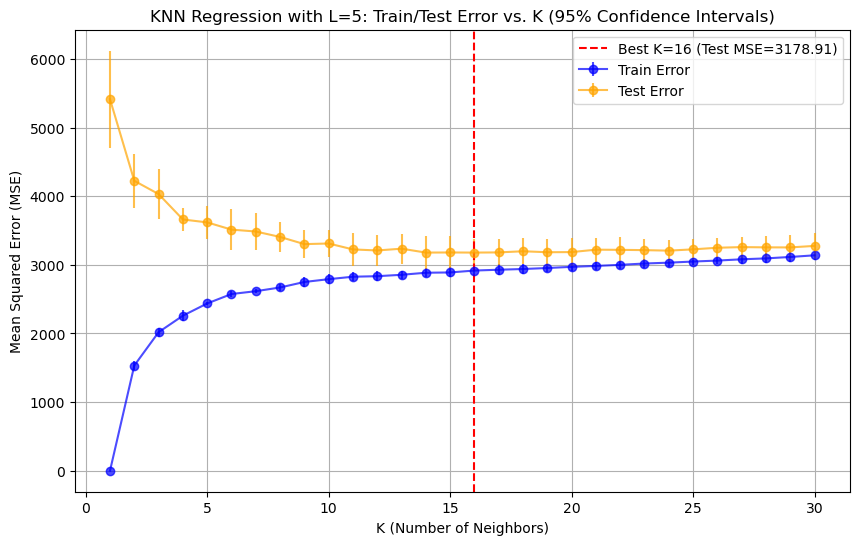

In [11]:
# MAIN EXPERIMENT with L=5
if __name__ == "__main__":
    # Load dataset
    data = load_diabetes()
    X, y = data.data, data.target
    
    # Run cross-validation experiment with L=5 and k=1..30
    results = evaluate_knn_cv(X, y, L=5, k_values=range(1, 31))
    
    # Find optimal k value (minimum test MSE)
    best_result = min(results, key=lambda x: x["test_mean"])
    best_k = best_result["k"]
    best_test_mse = best_result["test_mean"]
    best_train_mse = best_result["train_mean"]
    
    # Print results
    print(f"[L=5] Best K: {best_k}")
    print(f"[L=5] Test MSE at K={best_k}: {best_test_mse:.6f}")
    print(f"[L=5] Train MSE at K={best_k}: {best_train_mse:.6f}")
    
    # Prepare data for plotting
    ks = [r["k"] for r in results]
    train_means = [r["train_mean"] for r in results]
    train_stds = [r["train_std"] for r in results]
    test_means = [r["test_mean"] for r in results]
    test_stds = [r["test_std"] for r in results]
    
    # Create plot
    plt.figure(figsize=(10, 6))

    # with 95% probability, contains the true average error of the model on unseen data.
    # Plot training error with 95% confidence intervals
    plt.errorbar(ks, train_means, yerr=1.96 * np.array(train_stds) / np.sqrt(5), 
                 label="Train Error", fmt='-o', color='blue', alpha=0.7)
    
    # Plot test error with 95% confidence intervals
    plt.errorbar(ks, test_means, yerr=1.96 * np.array(test_stds) / np.sqrt(5), 
                 label="Test Error", fmt='-o', color='orange', alpha=0.7)
    
    # Highlight best k value
    plt.axvline(x=best_k, color='red', linestyle='--', 
                label=f'Best K={best_k} (Test MSE={best_test_mse:.2f})')
    
    # Format plot
    plt.xlabel("K (Number of Neighbors)")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("KNN Regression with L=5: Train/Test Error vs. K (95% Confidence Intervals)")
    plt.legend()
    plt.grid(True)
    plt.show()
    

[L=10] Best K: 19
[L=10] Test MSE at K=19: 3242.978046
[L=10] Train MSE at K=19: 2909.869651


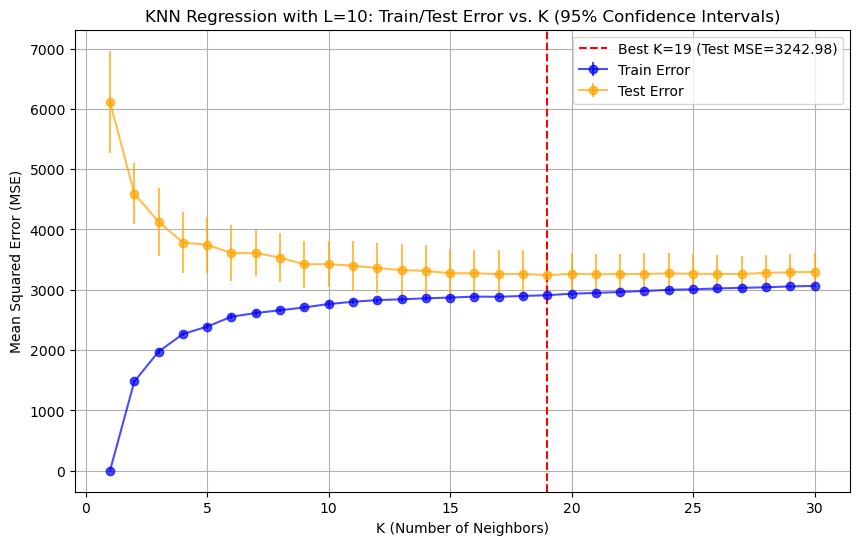

In [9]:
# Extension: Re-run experiment with L=10
results_L10 = evaluate_knn_cv(X, y, L=10, k_values=range(1, 31))

# Find best result for L=10
best_result_L10 = min(results_L10, key=lambda x: x["test_mean"])
best_k_L10 = best_result_L10["k"]
best_test_mse_L10 = best_result_L10["test_mean"]
best_train_mse_L10 = best_result_L10["train_mean"]

print(f"[L=10] Best K: {best_k_L10}")
print(f"[L=10] Test MSE at K={best_k_L10}: {best_test_mse_L10:.6f}")
print(f"[L=10] Train MSE at K={best_k_L10}: {best_train_mse_L10:.6f}")

# Plot for L=10
ks = [r["k"] for r in results_L10]
train_means = [r["train_mean"] for r in results_L10]
train_stds = [r["train_std"] for r in results_L10]
test_means = [r["test_mean"] for r in results_L10]
test_stds = [r["test_std"] for r in results_L10]

plt.figure(figsize=(10, 6))
plt.errorbar(ks, train_means, yerr=1.96 * np.array(train_stds) / np.sqrt(10), 
             label="Train Error", fmt='-o', color='blue', alpha=0.7)
plt.errorbar(ks, test_means, yerr=1.96 * np.array(test_stds) / np.sqrt(10), 
             label="Test Error", fmt='-o', color='orange', alpha=0.7)
plt.axvline(x=best_k_L10, color='red', linestyle='--', 
            label=f'Best K={best_k_L10} (Test MSE={best_test_mse_L10:.2f})')
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("KNN Regression with L=10: Train/Test Error vs. K (95% Confidence Intervals)")
plt.legend()
plt.grid(True)
plt.show()


### Comments on Question 2: Effect of the Parameter **K** (Number of Neighbors)

In KNN regression, the parameter **K** controls model complexity. For the diabetes dataset, we observe:

- **Small K (e.g., K = 1 to 5)**:
  - Very low training error, as the model fits the training data closely.
  - High and unstable test error.
  - This is a classic case of **overfitting** — the model is too flexible and memorizes noise from the training data.

- **Large K (e.g., K = 20 to 30)**:
  - Both training and test error are higher.
  - The model becomes too simple, averaging over many neighbors and losing important detail.
  - This is **underfitting**, where the model fails to capture underlying patterns.

- **Medium K (e.g., K = 10 to 20)**:
  - Balanced behavior — moderate training error and lower test error.
  - Test error reaches a minimum, indicating **optimal generalization**.
  - In our experiments, the best K was found to be **16 (L=5)** and **19 (L=10)**.

These observations illustrate the **bias-variance tradeoff**:  
- Small K → Low bias, high variance (overfitting)  
- Large K → High bias, low variance (underfitting)  

--------------------------------------------------------------------------------------------------------------------------

###  Effect of L in L-Fold Cross-Validation

We compare the results of KNN regression using **L = 5** and **L = 10** folds in cross-validation.

####  Fold Size & Evaluation Granularity
- **L = 5** means each fold contains ~88 samples (since diabetes has 442 samples).
- **L = 10** results in smaller folds (~44 samples), which leads to **more granular evaluation**.

####  Stability of Estimates
- The plot with **L = 10** shows slightly **narrower confidence intervals**, indicating more stable and consistent estimates across folds.
- The learning curves appear smoother with less fluctuation compared to L = 5, especially on the test error curve.

####  Best K and MSE
- For **L = 5**, the best K was **16** with a test MSE of **3178.913677**.
- For **L = 10**, the best K shifted to **19** with a slightly higher test MSE of **3242.988046**.
- This variation is expected due to differences in fold structure and sampling.

####  General Insights
- **Higher L (e.g., L = 10)**: Provides more reliable error estimates (lower variance), but at higher computational cost.
- **Lower L (e.g., L = 5)**: Faster to compute and still reliable, though confidence intervals are slightly wider.

####  Conclusion:
Using a larger number of folds (L = 10) gives **more stable and trustworthy performance estimates**, while smaller L (e.g., 5) is more efficient. Both approaches identified a K value in the same general region (K = 16–19), reinforcing that cross-validation is effective for model selection.



## Question 3: Automatic Model Selection

This part implements a `KnnRegressorCV` class that selects the optimal number of neighbors K using internal L-Fold cross-validation.


In [12]:
class KnnRegressorCV(BaseEstimator):
    """
    K-Nearest Neighbors regressor with automated K selection using cross-validation.
    
    Parameters:
    -----------
    ks : list of int, default=range(1, 21)
        Candidate values for K (number of neighbors) to evaluate
    cv : cross-validator object, default=LFold(5, random_state=42)
        Cross-validation strategy for K selection
    """
    
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5, random_state=42)):
        """Initialize the KNN CV model with candidate K values and CV strategy."""
        self.ks = ks
        self.cv = cv
    
    def fit(self, X, y):
        """
        Find optimal K using cross-validation and train final model.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Training data
        y : array-like, shape (n_samples,)
            Target values
            
        Returns:
        --------
        self : object
            Returns self with trained model and optimal K stored
        """
        best_k = None
        best_mse = float('inf')
        
        # Evaluate each candidate K value
        for k in self.ks:
            knn = KnnRegressor(k=k)
            mse_scores = []
            
            # Perform cross-validation for current K
            for train_idx, val_idx in self.cv.split(X):
                # Split data into training and validation folds
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                
                # Train and evaluate model
                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_val)
                mse_scores.append(mean_squared_error(y_val, y_pred))
            
            # Calculate average validation MSE across folds
            avg_mse = np.mean(mse_scores)
            
            # Update best K if current performance is better
            if avg_mse < best_mse:
                best_mse = avg_mse
                best_k = k
        
        # Store best K and train final model on full data with the best k
        self.k_ = best_k
        self.model_ = KnnRegressor(k=self.k_)
        self.model_.fit(X, y)
        
        return self
    
    def predict(self, X):
        """
        Predict using the model with optimal K.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Test samples
            
        Returns:
        --------
        y_pred : array, shape (n_samples,)
            Predicted target values
        """
        return self.model_.predict(X)
        

In [13]:
# MAIN EXECUTION 
if __name__ == "__main__":
    # Load diabetes dataset
    data = load_diabetes()
    X, y = data.data, data.target

    # Configure nested cross-validation
    outer_cv = LFold(5, random_state=42)  # Outer CV for performance evaluation
    chosen_ks = []  # Stores optimal K from each outer fold
    test_mses = []  # Stores test MSE from each outer fold

    # Perform nested cross-validation
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X)):
        # Inner CV loop: Select K using training data only
        knn_cv = KnnRegressorCV(ks=range(1, 21), cv=LFold(5)).fit(X[train_idx], y[train_idx])
        chosen_ks.append(knn_cv.k_)
        
        # Evaluate selected model on held-out test data
        test_mses.append(mean_squared_error(y[test_idx], knn_cv.predict(X[test_idx])))

        # Print per-fold results for transparency and debugging
        print(f"Fold {fold_idx+1}: Selected K={knn_cv.k_}, Test MSE={test_mses[-1]:.6f}")

    # Print final aggregated results
    print("\n=== Final Nested CV Results ===")
    print(f"Mean selected K value: {np.mean(chosen_ks):.1f}")
    print(f"Mean test MSE: {np.mean(test_mses):.6f} ± {np.std(test_mses):.6f}")
    print(f"Selected K values across folds: {chosen_ks}")
    

Fold 1: Selected K=15, Test MSE=3093.589394
Fold 2: Selected K=20, Test MSE=3446.037699
Fold 3: Selected K=16, Test MSE=3452.226607
Fold 4: Selected K=13, Test MSE=3166.042967
Fold 5: Selected K=17, Test MSE=3238.368589

=== Final Nested CV Results ===
Mean selected K value: 16.2
Mean test MSE: 3279.253051 ± 146.079448
Selected K values across folds: [15, 20, 16, 13, 17]


### Comments on Question 3: Effectiveness of Internal Cross-Validation

In this experiment, we used nested cross-validation to evaluate whether the KNN regressor with internal CV (KnnRegressorCV) can effectively choose the best number of neighbors, K.

Across 5 outer folds:
- The mean selected K was **16.2**
- The selected K values ranged from **13 to 20**
- The average test MSE was **3279.253051 ± 146.079448**

These selected K values align well with those observed in Question 2 (e.g., best K=16 for L=5, K=19 for L=10), confirming that internal CV consistently identifies good K values.

####  Was the internal CV successful?
Yes. The performance of the selected models on outer test folds shows that the internal cross-validation procedure generalizes well. Even though the "best" K might vary slightly per fold, the selections fall within a stable, low-error range.

####  What affects its success?
- The size of the training set in each outer fold (too small → less stable K).
- The number of inner folds (L) used for internal CV.
- The range and resolution of K values in `ks`.
- The amount of noise in the dataset (more noise → higher variance in selected K).
  
####  Conclusion:
Overall, internal CV is a reliable approach for **automatic model selection** and reduces the risk of manual tuning and overfitting.
